In [14]:
# import libraries
import os, zipfile
import numpy as np
import pandas as pd
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

from transformers import TFBertModel,  BertConfig, BertTokenizerFast

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

ValueError: ignored

In [2]:
#data = pd.read_pickle('data/data')
url = 'https://raw.githubusercontent.com/ziwei-z/w266-project/main/data/en-annotated.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=['sentence', 'label_raw'])
data['label_raw'] = data['label_raw'].str.split(',')
data['label'] = pd.to_numeric(data.label_raw.str[0])-1

train_X, test_X, train_Y, test_Y = train_test_split(data['sentence'], data['label'], test_size = 0.33, random_state=13)
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, test_size = 0.2, random_state=13)

In [3]:
data[data.label==3][0:5]

,sentence,label_raw,label
1791,( isaac crying ) - it's cranky time .,[4],3
1793,( laughter ) woman :,[4],3
1794,* don't want to be re-re-re-repossessed * * re...,[4],3
1795,* Uh-oh uh-oh ... Why did you take down the [L...,"[4, 7]",3
1796,A bomb ?,[4],3


In [ ]:
print(dev_X.astype(str).str.len().max())


222


In [4]:
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 100

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# look at the configuration
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [12]:
# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = input_ids

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
outputs = Dense(units=len(train_Y.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(pooled_output)

# And combine it all in a model object
model = Model(inputs=input_ids, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 100)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

In [ ]:
tran

In [16]:
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Tokenize the input (takes some time)
def tokenize(data):
    return tokenizer(
          text=data.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding='max_length', 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

x = tokenize(train_X)
x_dev = tokenize(dev_X)

# Fit the model
history = model.fit(
    x=x['input_ids'],
    y=to_categorical(train_Y),
    #validation_split = 0.2,
    validation_data=(x_dev['input_ids'], to_categorical(dev_Y)),
    batch_size=32,
    epochs=5)

Epoch 1/5
294/294 [==============================] - 413s 1s/step - loss: 1.6308 - accuracy: 0.3999 - val_loss: 1.3991 - val_accuracy: 0.4989
Epoch 2/5
294/294 [==============================] - 382s 1s/step - loss: 1.2222 - accuracy: 0.5724 - val_loss: 1.3649 - val_accuracy: 0.5151
Epoch 3/5
294/294 [==============================] - 382s 1s/step - loss: 1.0340 - accuracy: 0.6456 - val_loss: 1.3773 - val_accuracy: 0.5287
Epoch 4/5
294/294 [==============================] - 380s 1s/step - loss: 0.9084 - accuracy: 0.7015 - val_loss: 1.4219 - val_accuracy: 0.5181
Epoch 5/5
294/294 [==============================] - 381s 1s/step - loss: 0.8277 - accuracy: 0.7284 - val_loss: 1.4451 - val_accuracy: 0.5232


In [ ]:
#save model
path = "/content/drive/MyDrive/W266 Project/saved models"
model.save(path+'/bert1')

#pickle.dump(model, open(path + 'bert1', 'wb'))
#loaded_model = pickle.load(open('bert_1', 'rb'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/W266 Project/saved models/bert1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/W266 Project/saved models/bert1/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


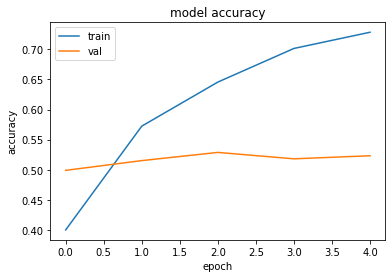

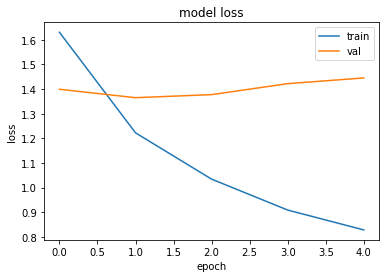

In [18]:
#graph 


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [17]:
#evaluate

x_test = tokenize(test_X)

# Run evaluation
model_eval = model.evaluate(
    x=x_test['input_ids'],
    y=to_categorical(test_Y)
)

181/181 [==============================] - 72s 397ms/step - loss: 1.4437 - accuracy: 0.5219


In [19]:
y_pred=model.predict(x_test['input_ids'])
y_pred_bool = np.argmax(y_pred, axis=1)

In [20]:
print(classification_report(test_Y, y_pred_bool))

              precision    recall  f1-score   support

           0       0.56      0.55      0.55      1242
           1       0.54      0.59      0.56       889
           2       0.43      0.34      0.38       517
           3       0.46      0.52      0.49       602
           4       0.62      0.61      0.62       613
           5       0.49      0.52      0.50       537
           6       0.46      0.45      0.46       464
           7       0.52      0.50      0.51       921

    accuracy                           0.52      5785
   macro avg       0.51      0.51      0.51      5785
weighted avg       0.52      0.52      0.52      5785



In [21]:
con_mat = tf.math.confusion_matrix(labels=test_Y, predictions=y_pred_bool).numpy()

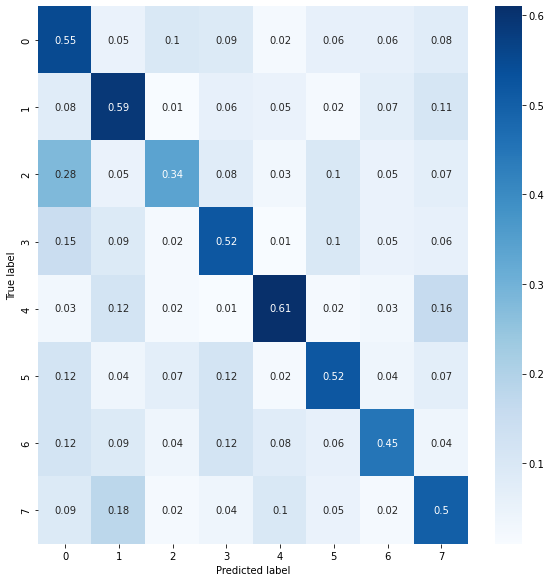

In [22]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = list(range(8))
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
list(range())

[0, 1, 2, 3, 4, 5, 6, 7, 8]